## Introduction and set up

In [1]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Prep the data

In [3]:
df = pd.read_csv(path/'train.csv')

In [4]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)

add_features(df)

In [5]:
splits = RandomSplitter(seed=42)(df)

In [6]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

/Users/bognaflieger/opt/miniforge3/envs/ml-playground/lib/python3.11/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


## Train the model

In [7]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.10000000149011612, valley=0.007585775572806597)

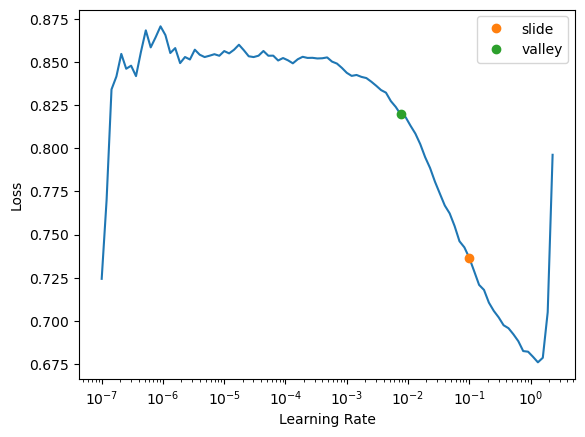

In [8]:
learn.lr_find(suggest_funcs=(slide, valley))

In [9]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.610143,0.576592,0.668539,00:00
1,0.527570,0.434029,0.808989,00:00
2,0.490081,0.437561,0.803371,00:00
3,0.478647,0.454835,0.803371,00:00
4,0.475361,0.495277,0.758427,00:00
5,0.468235,0.443766,0.792135,00:00
6,0.458272,0.413175,0.803371,00:00
7,0.449685,0.421339,0.814607,00:00
8,0.446912,0.423395,0.837079,00:00
9,0.443389,0.427153,0.814607,00:00


## Submit to Kaggle

In [10]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [11]:
tst_dl = learn.dls.test_dl(tst_df)

/Users/bognaflieger/opt/miniforge3/envs/ml-playground/lib/python3.11/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [31]:
preds,_ = learn.get_preds(dl=tst_dl)

# preds item is a list of two because we have two categories
# index 0 -> probability of category 1
# index 1 -> probability of category 2
preds[:5]

tensor([[0.8699, 0.1301],
        [0.3469, 0.6531],
        [0.5692, 0.4308],
        [0.8929, 0.1071],
        [0.3832, 0.6168]])

In [13]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [14]:
!head sub.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Ensembling

In [29]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    local_preds = learn.get_preds(dl=tst_dl)
    return local_preds[0]

In [30]:
learns = [ensemble() for _ in range(5)]

In [20]:
ens_preds = torch.stack(learns).mean(0)

In [24]:
x = learns[0]
x[:5]

tensor([[0.9148, 0.0852],
        [0.6058, 0.3942],
        [0.8906, 0.1094],
        [0.9116, 0.0884],
        [0.5278, 0.4722]])

In [18]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

## Final thoughts